In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import sys
import scipy.io
sys.path.append("..")
import ODE_Dynamics as od
import model as mdl
import Positive_Symptom_fn as fn
import simulation as sim

In [2]:
vload = sim.sample_viral_load()
prob_s_i0 = 0.55; prob_s_ibar0 = 0.1
p_threshold0 = 170306.4 * 1E-05
s_threshold0 = sim.get_symptom_threshold(vload)
start_day0 = 20
data = sim.simulate_epidemic(vload, start_day = start_day0,
                             prob_s_i = prob_s_i0, prob_s_ibar = prob_s_ibar0, 
                             v_threshold = p_threshold0)

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160


In [3]:
days = [float(i) + start_day0 + 1 for i in list(range(len(data)))]
tests = data[:,0]
positives = data[:,1]
test_data = np.column_stack((days, tests, positives))
test_data = tf.cast(test_data, dtype = tf.float32)
print(test_data)

tf.Tensor(
[[2.100e+01 1.019e+03 2.000e+00]
 [2.200e+01 9.850e+02 2.000e+00]
 [2.300e+01 1.012e+03 1.000e+00]
 [2.400e+01 9.970e+02 1.000e+00]
 [2.500e+01 9.590e+02 2.000e+00]
 [2.600e+01 9.790e+02 3.000e+00]
 [2.700e+01 1.007e+03 2.000e+00]
 [2.800e+01 9.600e+02 6.000e+00]
 [2.900e+01 9.700e+02 2.000e+00]
 [3.000e+01 1.019e+03 2.000e+00]
 [3.100e+01 9.310e+02 0.000e+00]
 [3.200e+01 9.800e+02 2.000e+00]
 [3.300e+01 9.980e+02 5.000e+00]
 [3.400e+01 1.007e+03 1.000e+00]
 [3.500e+01 9.540e+02 4.000e+00]
 [3.600e+01 9.320e+02 5.000e+00]
 [3.700e+01 9.670e+02 4.000e+00]
 [3.800e+01 9.100e+02 5.000e+00]
 [3.900e+01 1.023e+03 3.000e+00]
 [4.000e+01 9.360e+02 5.000e+00]
 [4.100e+01 1.026e+03 7.000e+00]
 [4.200e+01 9.610e+02 1.000e+01]
 [4.300e+01 9.280e+02 1.200e+01]
 [4.400e+01 9.360e+02 1.200e+01]
 [4.500e+01 9.280e+02 1.100e+01]
 [4.600e+01 9.690e+02 9.000e+00]
 [4.700e+01 9.190e+02 1.200e+01]
 [4.800e+01 9.100e+02 7.000e+00]
 [4.900e+01 9.300e+02 1.000e+01]
 [5.000e+01 9.140e+02 1.300e+01]

In [4]:
vdyn_ode_fn = od.ViralDynamics

In [5]:
positive_fn = fn.proba_pos_sym(p_threshold0).positive_fn
symptom_fn = fn.proba_pos_sym(s_threshold0).symptom_fn

In [6]:
prob_s_ibar = prob_s_ibar0

In [7]:
loglike = mdl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar = 0.1, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= start_day0, Epi_cadence = 0.5, Vir_cadence = 0.0625, phi_s = 0.6, psi_s = 0.05)

In [8]:
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)
L = 0.0025/beta
V0 = np.random.normal(1E3, 1E2, 1)
print(V0)
X0 = 1E6
Y0 = V0
par= tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
vpar = par
pospar = par
sympar = par

[1086.41226304]


In [9]:
sample_size = 1000
k = 1
index = 1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
L = 0.0025/beta

V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0

par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0,V0,X0,Y0]])

init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

while index <= sample_size - 1:
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    
    par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0,V0,X0,Y0]])
    par = np.concatenate((par, par_new), axis = 0)
    
    init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
    init_state = np.concatenate((init_state, init_state_new), 0)

    index +=1
        

vpar = tf.constant(par, dtype=tf.float32)
pospar = par
sympar = par
print(par.shape)

(1000, 9)


In [10]:
epipar = tf.constant(np.array([[1.8,  5.0E-08, 0.1, 0.001, 0.999]], dtype=np.float32))

In [11]:
ll,pp = loglike.__call__(test_data, epipar, vpar, pospar, sympar)

initial time
tf.Tensor(0.0, shape=(), dtype=float32)
final time
tf.Tensor(161.0, shape=(), dtype=float32)
printing estates shape
(1, 2, 322)
printing vload
[0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.001, 0.001, 0.0, 0.0, 0.003, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.0, 0.0, 0.002, 0.003, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.001, 0.002, 0.003, 0.0

In [18]:
C_xt = test_data[:,2]
N_xt = test_data[:,1]
pp_simu = C_xt/N_xt

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')
font = {'size'   : 9}
plt.rc('font', **font)

Text(0.5, 1, 'Test-positive probability likelihood function')

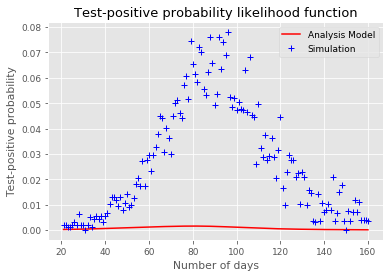

In [20]:
plt.plot(test_data[:,0], pp,"r-", label = "Analysis Model")
plt.plot(test_data[:,0], pp_simu, "b+", label = "Simulation")
plt.xlabel("Number of days")
plt.ylabel("Test-positive probability")
plt.legend(loc="upper right")
plt.savefig('simu_vs_code_psibar0.pdf', dpi=300, bbox_inches='tight')
plt.title("Test-positive probability likelihood function")

In [15]:
pp

<tf.Tensor: shape=(140, 1), dtype=float32, numpy=
array([[1.78359973e-04],
       [1.91305560e-04],
       [2.05037664e-04],
       [2.19575799e-04],
       [2.34934967e-04],
       [2.51128105e-04],
       [2.68168689e-04],
       [2.86066759e-04],
       [3.04828456e-04],
       [3.24458961e-04],
       [3.44963424e-04],
       [3.66340915e-04],
       [3.88567394e-04],
       [4.11645044e-04],
       [4.35575115e-04],
       [4.60351352e-04],
       [4.85958677e-04],
       [5.12374390e-04],
       [5.39565342e-04],
       [5.67490701e-04],
       [5.96265774e-04],
       [6.25885325e-04],
       [6.56204531e-04],
       [6.87081483e-04],
       [7.18377181e-04],
       [7.49955594e-04],
       [7.81686511e-04],
       [8.13446590e-04],
       [8.45117611e-04],
       [8.76594742e-04],
       [9.07770416e-04],
       [9.38519777e-04],
       [9.68717155e-04],
       [9.98259755e-04],
       [1.02711574e-03],
       [1.05528953e-03],
       [1.08277111e-03],
       [1.10959366e-03],


In [16]:
a = tf.stack([0.8,0.9], axis = 0)

In [17]:
b = tf.stack([a, tf.constant([4.])], axis = 1)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [2] != values[1].shape = [1] [Op:Pack] name: stack